In [1]:
import matplotlib.pyplot as plt
import gensim
import numpy as np
import spacy
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import os, re, operator, warnings
warnings.filterwarnings('ignore') # Let's not pay heed to them right now
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

In [3]:
path = 'yelp_data/health_text_sentiment_full.csv'

In [13]:
df = pd.read_csv(path)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df[['stars','clean_text']]
#df = df[['stars','text','clean_text']]

In [15]:
df.head()

,stars,clean_text
0,1,please stay away place bad care imaginable sta...
1,5,husband patient dr byrne last year half last m...
2,4,dr byrne great doctor great bed side manner ex...
3,3,raise review dr bryne receptive daughter go an...
4,1,wish could give star bad office ever horrible ...


## One and five stars

In [16]:
one_star = df.ix[np.where(df.stars==1)]
one_star.reset_index(drop=True,inplace=True)
five_star = df.ix[np.where(df.stars==5)]
five_star.reset_index(drop=True,inplace=True)

In [17]:
one_star.head()

,stars,clean_text
0,1,please stay away place bad care imaginable sta...
1,1,wish could give star bad office ever horrible ...
2,1,go emergency room kidney stone attack emergenc...
3,1,bad place ever dr bryne reschedule first appt ...
4,1,update last review situation get even bad urin...


## NLP

In [18]:
#nlp = spacy.load('en', parser=False, entity=False)
nlp = spacy.load('en')

In [ ]:
## test
test = one_star.loc[:100]
test.head()

In [ ]:
%%time
tokens = []
lemma = []
pos = []
for doc in nlp.pipe(test['clean_text'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)

test['tokens'] = tokens
test['lemma'] = lemma
test['POS'] = pos

In [ ]:
test.head()

## One stat

In [19]:
one_star.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21988 entries, 0 to 21987
Data columns (total 2 columns):
stars         21988 non-null int64
clean_text    21988 non-null object
dtypes: int64(1), object(1)
memory usage: 343.6+ KB


In [20]:
one_star.head()

,stars,clean_text
0,1,please stay away place bad care imaginable sta...
1,1,wish could give star bad office ever horrible ...
2,1,go emergency room kidney stone attack emergenc...
3,1,bad place ever dr bryne reschedule first appt ...
4,1,update last review situation get even bad urin...


## time

```
CPU times: user 59min 24s, sys: 6min 32s, total: 1h 5min 56s
Wall time: 8min 42s
    ```

In [21]:
%%time
lemma = []
for doc in nlp.pipe(one_star['clean_text'].astype('unicode').values, batch_size=50, n_threads=3):
    if doc.is_parsed:
        lemma.append([n.lemma_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        lemma.append(None)

one_star['lemma'] = lemma

CPU times: user 59min 24s, sys: 6min 32s, total: 1h 5min 56s
Wall time: 8min 42s


In [22]:
onestar_lemma = list(one_star.lemma)

## Bigram

In [23]:
%%time
bigram = gensim.models.Phrases(onestar_lemma)

CPU times: user 4.47 s, sys: 344 ms, total: 4.81 s
Wall time: 4.77 s


In [27]:
%%time
texts = [bigram[line] for line in onestar_lemma]

CPU times: user 11.9 s, sys: 719 ms, total: 12.6 s
Wall time: 12.6 s


In [28]:
texts[10]

['really',
 'like',
 'dr',
 'gibson',
 'gyn',
 'feel_comfortable',
 'talk',
 'insurance',
 'change',
 'since',
 'last',
 'appointment',
 'check',
 'insurance_carrier',
 'website',
 'addition',
 'central',
 'phx',
 'woman',
 'healthcare',
 'website',
 'yesterday',
 'dr',
 'gibson',
 'list',
 'carrier',
 'website',
 'insurance_carrier',
 'list',
 'central',
 'phxs',
 'website',
 'think',
 'cover',
 'base',
 'nope',
 'arrive',
 'appointment',
 'hand',
 'insurance_card',
 'tell',
 'not',
 'contract',
 'insurance_carrier',
 'website',
 'not',
 'date',
 'year',
 'keep',
 'website',
 'date',
 'delete',
 'page',
 'pay',
 'talk',
 'dr',
 'gibson',
 'maybe',
 'minute',
 'bp',
 'take',
 'weight',
 'no',
 'annual_exam',
 'get',
 'act_together',
 'central',
 'phx',
 'woman',
 'healthcare']

In [29]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [30]:
len(corpus)

21988

In [31]:
corpus[10]

[(6, 2),
 (36, 1),
 (49, 1),
 (53, 1),
 (57, 2),
 (92, 2),
 (93, 1),
 (137, 1),
 (139, 1),
 (161, 1),
 (192, 3),
 (218, 1),
 (221, 1),
 (269, 1),
 (288, 1),
 (290, 1),
 (325, 1),
 (379, 1),
 (423, 2),
 (479, 1),
 (521, 1),
 (522, 1),
 (523, 1),
 (524, 1),
 (525, 1),
 (526, 1),
 (527, 1),
 (528, 1),
 (529, 3),
 (530, 1),
 (531, 1),
 (532, 2),
 (533, 1),
 (534, 1),
 (535, 3),
 (536, 1),
 (537, 1),
 (538, 2),
 (539, 1),
 (540, 3),
 (541, 2),
 (542, 1),
 (543, 1),
 (544, 2),
 (545, 1),
 (546, 6),
 (547, 1),
 (548, 1),
 (549, 1)]

## LSI

In [32]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [33]:
lsimodel.show_topics(num_topics=5)

[(0,
  '0.600*"not" + 0.221*"get" + 0.219*"go" + 0.201*"call" + 0.195*"tell" + 0.189*"doctor" + 0.183*"would" + 0.180*"say" + 0.144*"see" + 0.138*"time"'),
 (1,
  '-0.621*"call" + 0.556*"not" + -0.249*"office" + -0.194*"appointment" + -0.176*"back" + -0.165*"get" + -0.156*"wait" + -0.123*"tell" + -0.104*"time" + -0.075*"would"'),
 (2,
  '0.549*"doctor" + -0.377*"call" + 0.375*"wait" + 0.243*"see" + 0.210*"time" + -0.199*"not" + 0.195*"appointment" + -0.194*"say" + 0.147*"office" + 0.141*"patient"'),
 (3,
  '0.402*"office" + -0.389*"go" + 0.332*"not" + -0.256*"say" + -0.254*"get" + 0.238*"call" + -0.234*"wait" + -0.200*"come" + 0.193*"doctor" + -0.146*"tell"'),
 (4,
  '-0.625*"doctor" + 0.431*"wait" + 0.275*"appointment" + -0.257*"go" + 0.253*"time" + 0.237*"not" + 0.158*"hour" + 0.108*"minute" + -0.104*"tell" + -0.097*"get"')]

## HDP

In [35]:
%%time
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

CPU times: user 25min 9s, sys: 3min 10s, total: 28min 19s
Wall time: 3min 40s


In [40]:
 hdpmodel.show_topics()

[(0,
  '0.039*not + 0.015*go + 0.014*get + 0.013*call + 0.013*doctor + 0.012*tell + 0.012*would + 0.011*say + 0.010*see + 0.010*time + 0.009*office + 0.008*wait + 0.008*back + 0.008*appointment + 0.008*no + 0.007*take + 0.007*come + 0.006*one + 0.006*ask + 0.006*dr'),
 (1,
  '0.038*not + 0.015*go + 0.014*get + 0.013*doctor + 0.012*call + 0.012*would + 0.011*tell + 0.010*say + 0.010*see + 0.009*time + 0.009*office + 0.009*wait + 0.008*back + 0.008*appointment + 0.007*no + 0.007*take + 0.007*dr + 0.007*come + 0.006*patient + 0.006*one'),
 (2,
  '0.038*not + 0.015*go + 0.014*get + 0.012*call + 0.012*doctor + 0.011*would + 0.011*tell + 0.010*time + 0.009*see + 0.009*say + 0.009*office + 0.008*wait + 0.008*back + 0.008*appointment + 0.008*dr + 0.007*no + 0.007*take + 0.006*one + 0.006*patient + 0.006*never'),
 (3,
  '0.035*not + 0.014*go + 0.013*get + 0.012*doctor + 0.011*call + 0.010*time + 0.010*office + 0.010*wait + 0.009*would + 0.009*tell + 0.009*see + 0.008*say + 0.007*appointment + 0

NameError: name 'hpd_topics_topics' is not defined

## LDA

In [41]:
%%time
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

CPU times: user 54.6 s, sys: 2.3 s, total: 56.9 s
Wall time: 38.7 s


In [42]:
lda_topics = ldamodel.show_topics(num_topics=5)

In [43]:
for i,j in lda_topics:
    print('TOPIC:{}\n\nresult:{}\n'.format(i,j))


TOPIC:7

result:0.046*"not" + 0.023*"go" + 0.019*"get" + 0.016*"tell" + 0.015*"say" + 0.014*"doctor" + 0.010*"ask" + 0.010*"take" + 0.010*"would" + 0.010*"back"

TOPIC:0

result:0.042*"not" + 0.013*"go" + 0.011*"doctor" + 0.011*"care" + 0.010*"get" + 0.009*"see" + 0.009*"eye" + 0.009*"would" + 0.007*"glass" + 0.007*"one"

TOPIC:2

result:0.022*"not" + 0.014*"go" + 0.014*"would" + 0.012*"dr" + 0.010*"office" + 0.009*"tell" + 0.009*"say" + 0.009*"get" + 0.008*"could" + 0.007*"make"

TOPIC:1

result:0.047*"wait" + 0.036*"not" + 0.027*"time" + 0.023*"hour" + 0.022*"appointment" + 0.020*"see" + 0.015*"doctor" + 0.015*"go" + 0.015*"minute" + 0.014*"get"

TOPIC:6

result:0.048*"not" + 0.019*"staff" + 0.016*"patient" + 0.015*"office" + 0.013*"would" + 0.012*"rude" + 0.012*"doctor" + 0.010*"go" + 0.009*"dr" + 0.008*"see"



In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.023007  0.019921       1        1  23.415783
4     -0.027333 -0.098490       2        1  14.922276
1     -0.106645 -0.063049       3        1  14.382961
6     -0.032519 -0.017118       4        1  12.348594
8      0.029775  0.122996       5        1   7.888066
0      0.039643  0.028962       6        1   7.386270
9      0.053030 -0.057658       7        1   6.794531
2     -0.013142  0.084846       8        1   5.018239
3      0.166156 -0.047226       9        1   4.255845
5     -0.085958  0.026817      10        1   3.587439, topic_info=     Category          Freq           Term         Total  loglift  logprob
term                                                                      
246   Default  14765.000000           wait  14765.000000  30.0000  30.0000
17    Default  22259.000000           call  22259.000000  29.0000  29.0000
553   Default   4708.000000           bill   4708.000000  28.0000  28.0000
269   Default   5309.000000            pay   5309.000000  27.0000  27.0000
57    Default  65671.000000            not  65671.000000  26.0000  26.0000
137   Default   6081.000000      insurance   6081.000000  25.0000  25.0000
63    Default   3726.000000           pain   3726.000000  24.0000  24.0000
6     Default  13280.000000    appointment  13280.000000  23.0000  23.0000
41    Default   7539.000000           hour   7539.000000  22.0000  22.0000
192   Default  10799.000000             dr  10799.000000  21.0000  21.0000
239   Default   2771.000000        surgery   2771.000000  20.0000  20.0000
59    Default  16253.000000         office  16253.000000  19.0000  19.0000
438   Default   3048.000000         charge   3048.000000  18.0000  18.0000
164   Default  16102.000000           time  16102.000000  17.0000  17.0000
1773  Default   2235.000000            son   2235.000000  16.0000  16.0000
118   Default  21177.000000         doctor  21177.000000  15.0000  15.0000
38    Default  24471.000000             go  24471.000000  14.0000  14.0000
230   Default   5140.000000           room   5140.000000  13.0000  13.0000
53    Default   5421.000000         minute   5421.000000  12.0000  12.0000
87    Default   8250.000000          staff   8250.000000  11.0000  11.0000
93    Default  19494.000000           tell  19494.000000  10.0000  10.0000
36    Default  23926.000000            get  23926.000000   9.0000   9.0000
96    Default   5806.000000          visit   5806.000000   8.0000   8.0000
76    Default   3953.000000           rude   3953.000000   7.0000   7.0000
78    Default  17310.000000            say  17310.000000   6.0000   6.0000
574   Default   2831.000000           test   2831.000000   5.0000   5.0000
158   Default   3780.000000           send   3780.000000   4.0000   4.0000
205   Default   3610.000000       hospital   3610.000000   3.0000   3.0000
1279  Default   1434.000000            eye   1434.000000   2.0000   2.0000
157   Default  16034.000000            see  16034.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
1400  Topic10    265.802490            kid   1119.294189   1.8900  -5.4226
3278  Topic10     79.853172  ear_infection    175.252563   2.5417  -6.6252
192   Topic10    887.492065             dr  10799.173828   0.8289  -4.2169
897   Topic10    483.339569         -PRON-   3824.616455   1.2592  -4.8246
118   Topic10   1223.533813         doctor  21177.470703   0.4765  -3.8959
414   Topic10    222.783279           sick   1385.927124   1.4998  -5.5991
36    Topic10    869.938293            get  23926.804688   0.0134  -4.2369
164   Topic10    654.424438           time  16102.605469   0.1248  -4.5216
57    Topic10   1251.630127            not  65671.023438  -0.6325  -3.8731
12    Topic10    386.794434            bad   5814.496094   0.6175  -5.0475
78    Topic10    633.885132            say  17310.824219   0.0205  -4.5535
574   Top

## Topic coherence

In [45]:
%%time
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

CPU times: user 1.83 s, sys: 547 ms, total: 2.38 s
Wall time: 994 ms


In [46]:
%%time
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

CPU times: user 8.28 s, sys: 10.6 s, total: 18.9 s
Wall time: 40.1 s


In [48]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

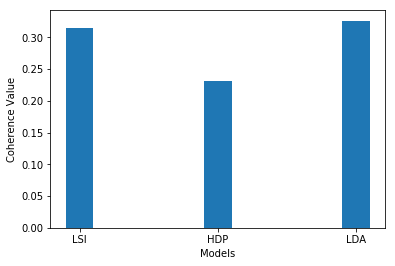

In [49]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
['LSI', 'HDP', 'LDA'])

In [52]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

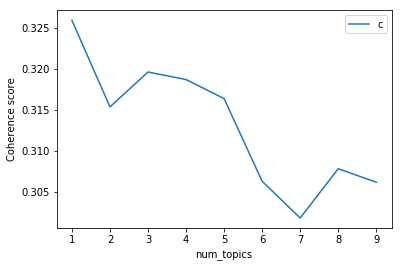

CPU times: user 7min 42s, sys: 54.4 s, total: 8min 36s
Wall time: 6min 43s


In [53]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=texts, limit=10)

In [56]:
ldamodel

In [59]:
ls

five_text_analysis.ipynb*     model/
health_Models-Copy1.ipynb*    Model_comparison.ipynb*
health_Models.ipynb*          MultinomialNB_NLP.ipynb*
health_SVC_clean_text.ipynb*  old_models/
health_SVC.ipynb*             onestar_text_analysis.ipynb*
Logistic_NLP.ipynb*           yelp_data/


In [55]:
lda_topics

[(7,
  '0.046*"not" + 0.023*"go" + 0.019*"get" + 0.016*"tell" + 0.015*"say" + 0.014*"doctor" + 0.010*"ask" + 0.010*"take" + 0.010*"would" + 0.010*"back"'),
 (0,
  '0.042*"not" + 0.013*"go" + 0.011*"doctor" + 0.011*"care" + 0.010*"get" + 0.009*"see" + 0.009*"eye" + 0.009*"would" + 0.007*"glass" + 0.007*"one"'),
 (2,
  '0.022*"not" + 0.014*"go" + 0.014*"would" + 0.012*"dr" + 0.010*"office" + 0.009*"tell" + 0.009*"say" + 0.009*"get" + 0.008*"could" + 0.007*"make"'),
 (1,
  '0.047*"wait" + 0.036*"not" + 0.027*"time" + 0.023*"hour" + 0.022*"appointment" + 0.020*"see" + 0.015*"doctor" + 0.015*"go" + 0.015*"minute" + 0.014*"get"'),
 (6,
  '0.048*"not" + 0.019*"staff" + 0.016*"patient" + 0.015*"office" + 0.013*"would" + 0.012*"rude" + 0.012*"doctor" + 0.010*"go" + 0.009*"dr" + 0.008*"see"')]

In [60]:
from gensim.test.utils import datapath
# Save model to disk.
ldamodel.save('onestar_lda.model')

In [ ]:
# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)